## 机器学习之类别不平衡问题 (3) —— 采样方法

<font size=2>

前两篇主要谈类别不平衡问题的评估方法，重心放在各类评估指标以及ROC和PR曲线上，只有在明确了这些后，我们才能据此选择具体的处理类别不平衡问题的方法。本篇介绍的采样方法是其中比较常用的方法，其主要目的是通过改变原有的不平衡样本集，以期获得一个平衡的样本分布，进而学习出合适的模型。

采样方法大致可分为过采样 (oversampling) 和欠采样 (undersampling) ，虽然过采样和降采样主题思想简单，但这些年来研究出了很多变种，本篇挑一些来具体阐述。见下思维导图：

<font>

![](https://raw.githubusercontent.com/massquantity/Class-Imbalance/master/image/Sampling%2BMethods.png)

### 过采样

#### 1) 随机过采样

随机过采样顾名思义就是从样本少的类别中随机抽样，再将抽样得来的样本添加到数据集中。然而这种方法如今已经不大使用了，因为重复采样往往会导致严重的过拟合，因而现在的主流过采样方法是通过某种方式人工合成一些少数类样本，从而达到类别平衡的目的，而这其中的鼻祖就是SMOTE。

#### 2) SMOTE

SMOTE(synthetic minority oversampling technique)的思想概括起来就是在少数类样本之间进行插值来产生额外的样本。具体地，对于一个少数类样本$\mathbf{x}_i$使用K近邻法(k值需要提前指定)，求出离$\mathbf{x}_i$距离最近的k个少数类样本，其中距离定义为样本之间n维特征空间的欧氏距离。然后从k个近邻点中随机选取一个，使用下列公式生成新样本：  

$$ \mathbf{x}_{new}=\mathbf{x}_{i}+(\mathbf{\hat{x}}_{i}-\mathbf{x}_{i}) \times \delta \tag{1.1}$$  

其中$\mathbf{\hat{x}}$为选出的k近邻点，$\delta\in[0,1]$是一个随机数。下图就是一个SMOTE生成样本的例子，使用的是3-近邻，可以看出SMOTE生成的样本一般就在$\mathbf{x}_{i}$和$\mathbf{\hat{x}}_{i}$相连的直线上：


![](https://raw.githubusercontent.com/massquantity/Class-Imbalance/master/image/1.png)

SMOTE会随机选取少数类样本用以合成新样本，而不考虑周边样本的情况，这样容易带来两个问题：
1. 如果选取的少数类样本周围也都是少数类样本，则新合成的样本不会提供太多有用信息。这就像支持向量机中远离margin的点对决策边界影响不大。
2. 如果选取的少数类样本周围都是多数类样本，这类的样本可能是噪音，则新合成的样本会与周围的多数类样本产生大部分重叠，致使分类困难。

总的来说我们希望新合成的少数类样本能处于两个类别的边界附近，这样往往能提供足够的信息用以分类。而这就是下面的`Border-line SMOTE`算法要做的事情。

#### 3) Border-line SMOTE 
这个算法会先将所有的少数类样本分成三类，如下图所示：
+ **"noise"** ： 所有的k近邻个样本都属于**多数类**
+ **"danger"** ： 超过一半的k近邻样本属于**多数类**
+ **"safe"**： 超过一半的k近邻样本属于**少数类**


![](https://raw.githubusercontent.com/massquantity/Class-Imbalance/master/image/2.png)

`Border-line SMOTE`算法只会从处于**”danger“**状态的样本中随机选择，然后用SMOTE算法产生新的样本。处于”danger“状态的样本代表靠近”边界“附近的少数类样本，而处于边界附近的样本往往更容易被误分类。因而`Border-line SMOTE`只对那些靠近”边界“的少数类样本进行人工合成样本，而`SMOTE`则对所有少数类样本一视同仁。  

`Border-line SMOTE`分为两种: `Borderline-1 SMOTE`和`Borderline-2 SMOTE`。 `Borderline-1 SMOTE`在合成样本时(1.1)式中的$\mathbf{\hat{x}}$是一个少数类样本，而`Borderline-2 SMOTE`中的$\mathbf{\hat{x}}$则是k近邻中的任意一个样本。

#### 4) ADASYN 

ADASYN名为自适应合成抽样(adaptive synthetic sampling)，其最大的特点是采用某种机制自动决定每个少数类样本需要产生多少合成样本，而不是像SMOTE那样对每个少数类样本合成同数量的样本。具体流程如下：

1. 首先计算需要合成的样本总量：  
$$ G = (S_{maj} - S_{min}) \times \beta $$  
其中$S_{maj}$为多数类样本数量，$S_{min}$为少数类样本数量，$\beta \in [0,1]$为系数。G即为总共想要合成的少数类样本数量，如果$\beta=1$则是合成后各类别数目相等。  
<br>
2. 对于每个少类别样本$\mathbf{x}_i$，找出其K近邻个点，并计算：  
$$ \Gamma_i = \frac{\Delta_i\,/\,K}{Z}$$  
其中$\Delta_i$为K近邻个点中多数类样本的数量，Z为规范化因子以确保$\Gamma$构成一个分布。这样若一个少数类样本$\mathbf{x}_i$的周围多数类样本越多，则其$\Gamma_i$也就越高。  
<br>
3. 最后对每个少类别样本$\mathbf{x}_i$计算需要合成的样本数量$g_i$，再用SMOTE算法合成新样本：  
$$g_i = \Gamma_i \times G$$
  
可以看到ADASYN利用分布$\Gamma$来自动决定每个少数类样本所需要合成的样本数量，这等于是给每个少数类样本施加了一个权重，周围的多数类样本越多则权重越高。ADASYN的缺点是易受离群点的影响，如果一个少数类样本的K近邻都是多数类样本，则其权重会变得相当大，进而会在其周围生成较多的样本。

下面利用了sklearn中的make_classification构造了一个不平衡数据集，各类别比例为`{0:54, 1:946}`。原始数据，`SMOTE`，`Borderline-1 SMOTE`，`Borderline-2 SMOTE`和`ADASYN`的比较见下图，左侧为过采样后的决策边界，右侧为过采样后的样本分布情况，**可以看到过采样后原来少数类的决策边界都扩大了，导致更多的多数类样本被划为少数类了**：

![](https://raw.githubusercontent.com/massquantity/Class-Imbalance/master/image/6.png)

从上图我们也可以比较几种过采样方法各自的特点。用SMOTE合成的样本分布比较平均，而`Border-line SMOTE`合成的样本则集中在类别边界处。`ADASYN`的特性是一个少数类样本周围多数类样本越多，则算法会为其生成越多的样本，从图中也可以看到生成的样本大都来自于原来与多数类比较靠近的那些少数类样本。

---

### 欠采样  

#### 1) 随机欠采样

随机欠采样的思想同样比较简单，就是从多数类样本中随机选取一些剔除掉。这种方法的缺点是被剔除的样本可能包含着一些重要信息，致使学习出来的模型效果不好。  

#### 2) EasyEnsemble 和 BalanceCascade
EasyEnsemble和BalanceCascade采用集成学习机制来处理传统随机欠采样中的信息丢失问题。

+ **EasyEnsemble**将多数类样本随机划分成n个子集，每个子集的数量等于少数类样本的数量，这相当于欠采样。接着将每个子集与少数类样本结合起来分别训练一个模型，最后将n个模型集成，这样虽然每个子集的样本少于总体样本，但集成后总信息量并不减少。  
<br>
+ 如果说EasyEnsemble是基于无监督的方式从多数类样本中生成子集进行欠采样，那么**BalanceCascade**则是采用了有监督结合Boosting的方式。在第n轮训练中，将从多数类样本中抽样得来的子集与少数类样本结合起来训练一个基学习器H，训练完后多数类中能被H正确分类的样本会被剔除。在接下来的第n+1轮中，从被剔除后的多数类样本中产生子集用于与少数类样本结合起来训练，最后将不同的基学习器集成起来。BalanceCascade的有监督表现在每一轮的基学习器起到了在多数类中选择样本的作用，而其Boosting特点则体现在每一轮丢弃被正确分类的样本，进而后续基学习器会更注重那些之前分类错误的样本。

#### 3) NearMiss  

NearMiss本质上是一种原型选择(prototype selection)方法，即从多数类样本中选取最具代表性的样本用于训练，主要是为了缓解随机欠采样中的信息丢失问题。NearMiss采用一些启发式的规则来选择样本，根据规则的不同可分为3类：
+ **NearMiss-1**：选择到最近的K个少数类样本平均距离最近的多数类样本
+ **NearMiss-2**：选择到最远的K个少数类样本平均距离最近的多数类样本
+ **NearMiss-3**：对于每个少数类样本选择K个最近的多数类样本，目的是保证每个少数类样本都被多数类样本包围

NearMiss-1和NearMiss-2的计算开销很大，因为需要计算每个多类别样本的K近邻点。另外，NearMiss-1易受离群点的影响，如下面第二幅图中合理的情况是处于边界附近的多数类样本会被选中，然而由于右下方一些少数类离群点的存在，其附近的多数类样本就被选择了。相比之下NearMiss-2和NearMiss-3不易产生这方面的问题。

![](https://raw.githubusercontent.com/massquantity/Class-Imbalance/master/image/7.png)

#### 4) 数据清洗方法(data cleaning tichniques)  

这类方法主要通过某种规则来清洗重叠的数据，从而达到欠采样的目的，这些规则往往也是启发性的，下面进行简要阐述：  

+ **Tomek Link**：Tomek Link表示不同类别之间距离最近的一对样本，即这两个样本互为最近邻且分属不同类别。这样如果两个样本形成了一个Tomek Link，则要么其中一个是噪音，要么两个样本都在边界附近。这样通过移除Tomek Link就能“清洗掉”类间重叠样本，使得互为最近邻的样本皆属于同一类别，从而能更好地进行分类。  
 下图左上为原始数据，右上为SMOTE后的数据，左下虚线标识出Tomek Link，右下为移除Tomek Link后的数据集，可以看到不同类别之间样本重叠减少了很多。  

![](https://raw.githubusercontent.com/massquantity/Class-Imbalance/master/image/4.png)

+ **Edited Nearest Neighbours(ENN)**：对于属于多数类的一个样本，如果其K个近邻点有超过一半都不属于多数类，则这个样本会被剔除。这个方法的另一个变种是所有的K个近邻点都不属于多数类，则这个样本会被剔除。

最后，数据清洗技术最大的缺点是无法控制欠采样的数量。由于都在某种程度上采用了K近邻法，而事实上大部分多数类样本周围也都是多数类，因而能剔除的多数类样本比较有限。

### 过采样和欠采样结合  

上文中提到SMOTE算法的缺点是生成的少数类样本容易与周围的多数类样本产生重叠难以分类，而数据清洗技术恰好可以处理掉重叠样本，所以可以将二者结合起来形成一个pipeline，先过采样再进行数据清洗。主要的方法是SMOTE + ENN和SMOTE + Tomek，其中SMOTE + ENN通常能清除更多的重叠样本，如下图：

![](https://raw.githubusercontent.com/massquantity/Class-Imbalance/master/image/8.png)

综上，本文简要介绍了几种过采样和欠采样的方法，其实还有更多的变种，可参阅`imbalanced-learn`最后列出的的[References](https://github.com/scikit-learn-contrib/imbalanced-learn) 。

![](https://raw.githubusercontent.com/massquantity/Class-Imbalance/master/image/5.png)

-----

In [1]:
from collections import Counter

import matplotlib.pyplot as plt
import numpy as np

from sklearn.datasets import make_classification
from sklearn.svm import LinearSVC

from imblearn.pipeline import make_pipeline
from imblearn.over_sampling import ADASYN, SMOTE, RandomOverSampler
from imblearn.base import SamplerMixin
from imblearn.utils import hash_X_y

In [2]:
def create_dataset(n_samples=1000, weights=(0.01, 0.01, 0.98), n_classes=3,
                   class_sep=0.8, n_clusters=1):
    return make_classification(n_samples=n_samples, n_features=2,
                               n_informative=2, n_redundant=0, n_repeated=0,
                               n_classes=n_classes,
                               n_clusters_per_class=n_clusters,
                               weights=list(weights),
                               class_sep=class_sep, random_state=0)

In [3]:
def plot_resampling(X, y, sampling, ax):
    X_res, y_res = sampling.fit_sample(X, y)
    ax.scatter(X_res[:, 0], X_res[:, 1], c=y_res, alpha=0.8, edgecolor='k')
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.get_xaxis().tick_bottom()
    ax.get_yaxis().tick_left()
    ax.spines['left'].set_position(('outward', 10))
    ax.spines['bottom'].set_position(('outward', 10))
    return Counter(y_res)

In [4]:
def plot_decision_function(X, y, clf, ax):
    plot_step = 0.02
    x_min, x_max = X[:, 0].min() - 1, X[:, 0].max() + 1
    y_min, y_max = X[:, 1].min() - 1, X[:, 1].max() + 1
    xx, yy = np.meshgrid(np.arange(x_min, x_max, plot_step),
                         np.arange(y_min, y_max, plot_step))

    Z = clf.predict(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)
    ax.contourf(xx, yy, Z, alpha=0.4)
    ax.scatter(X[:, 0], X[:, 1], alpha=0.8, c=y, edgecolor='k')

In [5]:
class Original(SamplerMixin):

    def fit(self, X, y):
        self.ratio_ = 1
        self.X_hash_ = hash_X_y(X, y)
        return self

    def sample(self, X, y):
        return X,

    def _sample(self, X, y):
        pass

    def fit_sample(self, X, y):
        return X, y

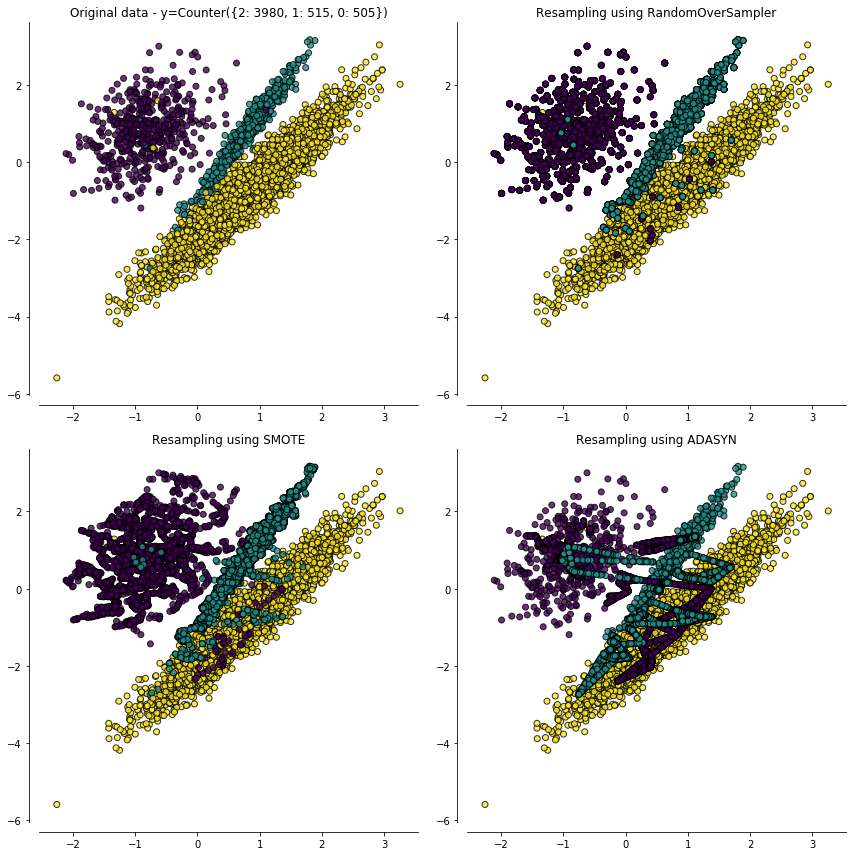

In [20]:
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(12, 12))
X, y = create_dataset(n_samples=5000, weights=(0.1, 0.1, 0.8), n_classes=3)
sampler = FakeSampler()
clf = make_pipeline(sampler, LinearSVC())
plot_resampling(X, y, sampler, ax1)
ax1.set_title('Original data - y={}'.format(Counter(y)))

ax_arr = (ax2, ax3, ax4)
for ax, sampler in zip(ax_arr, (RandomOverSampler(random_state=0),
                                SMOTE(random_state=0),
                                ADASYN(random_state=0, n_neighbors=3))):
    clf = make_pipeline(sampler, LinearSVC())
    clf.fit(X, y)
    plot_resampling(X, y, sampler, ax)
    ax.set_title('Resampling using {}'.format(sampler.__class__.__name__))
fig.tight_layout()

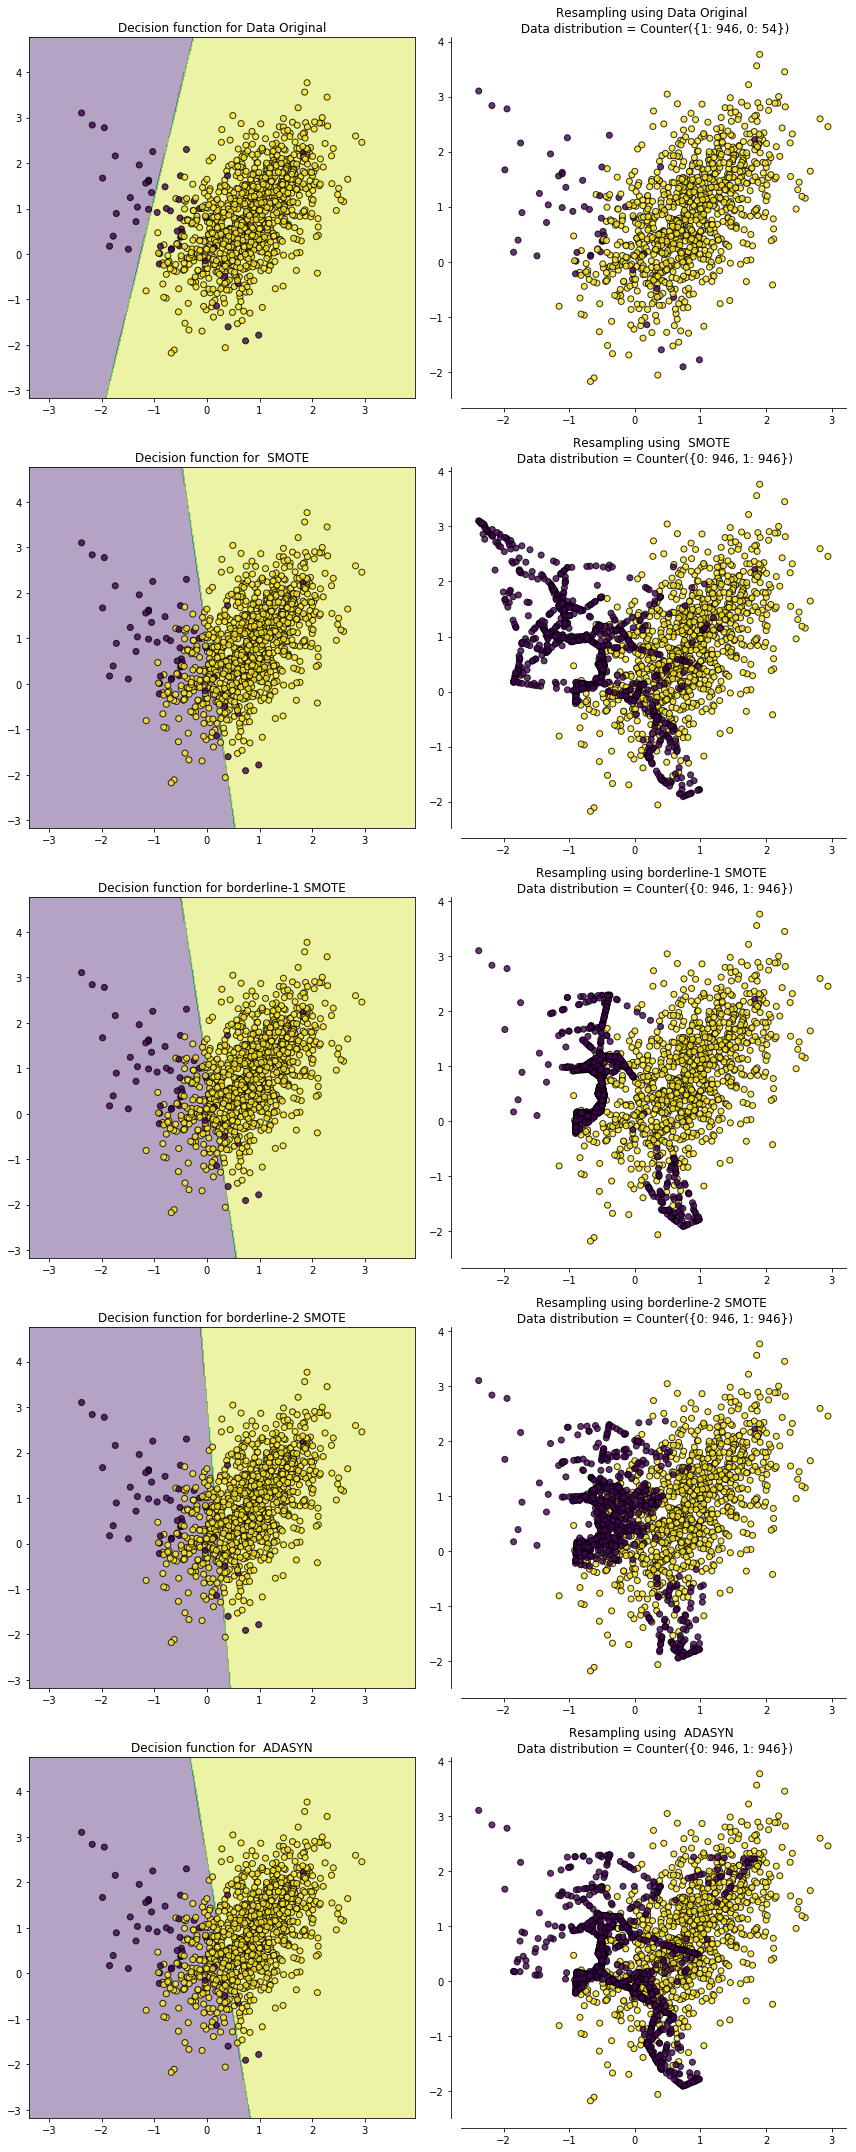

In [13]:
fig, ((ax1, ax2), (ax3, ax4), (ax5, ax6), (ax7, ax8), (ax9, ax10)) = plt.subplots(5, 2, figsize=(12, 30))
X, y = create_dataset(n_samples=1000, weights=(0.05, 0.95), class_sep=0.8, n_classes=2)

ax_arr = ((ax1, ax2), (ax3, ax4), (ax5, ax6), (ax7, ax8), (ax9, ax10))
names = ['Data','', 'borderline-1', 'borderline-2', '']
for name, ax, sampler in zip(names, ax_arr, 
                            (Original(),
                            SMOTE(random_state=42),
                            SMOTE(random_state=42, kind='borderline1'),  # ratio='minority', n_neighbors=?, m_neightbors=?
                            SMOTE(random_state=42, kind='borderline2'),
                            ADASYN(random_state=42))):   # ratio='minprity, n_neighbors=?
    clf = make_pipeline(sampler, LinearSVC())   # LR, NB, SVM, RF, GBDT
    clf.fit(X, y)
    plot_decision_function(X, y, clf, ax[0])
    ax[0].set_title('Decision function for {} {}'.format(name, sampler.__class__.__name__))
    X_res, y_res = sampler.fit_sample(X, y)
    plot_resampling(X, y, sampler, ax[1])
    ax[1].set_title('Resampling using {} {} \n Data distribution = {}'.format(name, sampler.__class__.__name__, Counter(y_res)))
fig.tight_layout()

----

In [53]:
def plot_resampling(X, y, sampling, ax):
    X_res, y_res = sampling.fit_sample(X, y)
    ax.scatter(X_res[:, 0], X_res[:, 1], c=y_res, alpha=0.8, edgecolor='k')
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.get_xaxis().tick_bottom()
    ax.get_yaxis().tick_left()
    ax.spines['left'].set_position(('outward', 10))
    ax.spines['bottom'].set_position(('outward', 10))
    ax.set_xlim([-2.5,3.5])
    ax.set_ylim([-6,4])
    return Counter(y_res)

In [4]:
from imblearn.under_sampling import RandomUnderSampler, NearMiss, EditedNearestNeighbours, TomekLinks

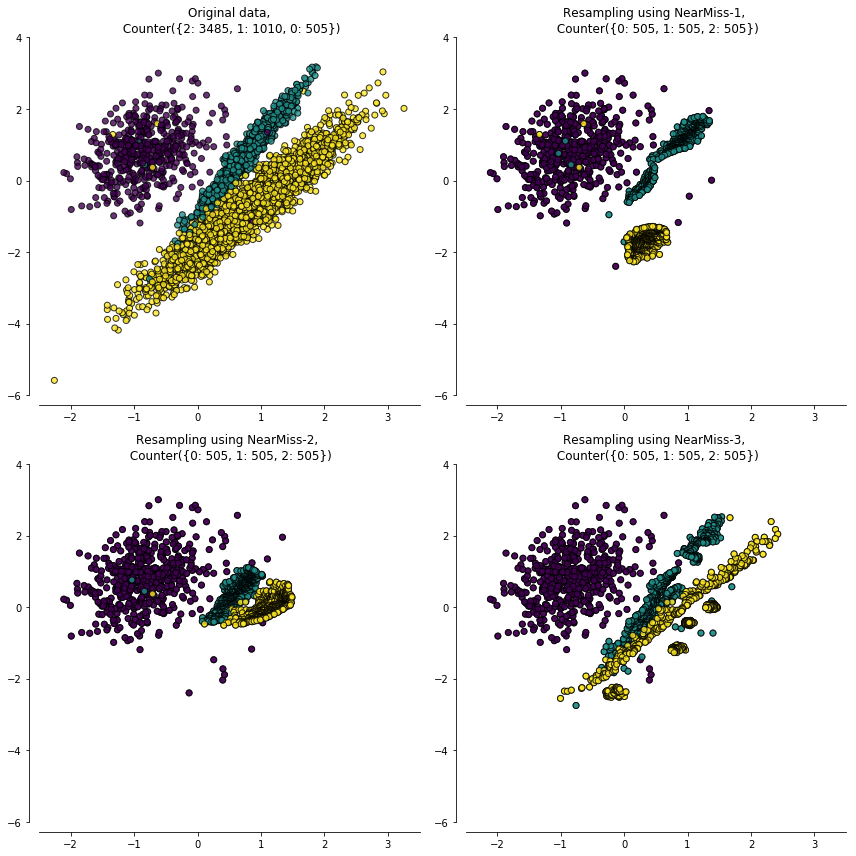

In [56]:
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(12,12))

X, y = create_dataset(n_samples=5000, weights=(0.1, 0.2, 0.7), class_sep=0.8)

plot_resampling(X, y, Original(), ax1)
ax1.set_title("Original data,\n {}".format(Counter(y)))
ax_arr = (ax2, ax3, ax4)
for ax, sampler in zip(ax_arr, (NearMiss(version=1, random_state=42),
                                NearMiss(version=2, random_state=42),
                                NearMiss(version=3, random_state=42, n_neighbors_ver3=50))):
    plot_resampling(X, y, sampler, ax)
    ax.set_title('Resampling using {}-{}, \n {}'.format(
        sampler.__class__.__name__, sampler.version, plot_resampling(X, y, sampler, ax)))
fig.tight_layout()

-----

In [6]:
def plot_resampling(X, y, sampling, ax):
    X_res, y_res = sampling.fit_sample(X, y)
    ax.scatter(X_res[:, 0], X_res[:, 1], c=y_res, alpha=0.8, edgecolor='k')
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.get_xaxis().tick_bottom()
    ax.get_yaxis().tick_left()
    ax.spines['left'].set_position(('outward', 10))
    ax.spines['bottom'].set_position(('outward', 10))
    return Counter(y_res)

In [5]:
from imblearn.combine import SMOTEENN, SMOTETomek

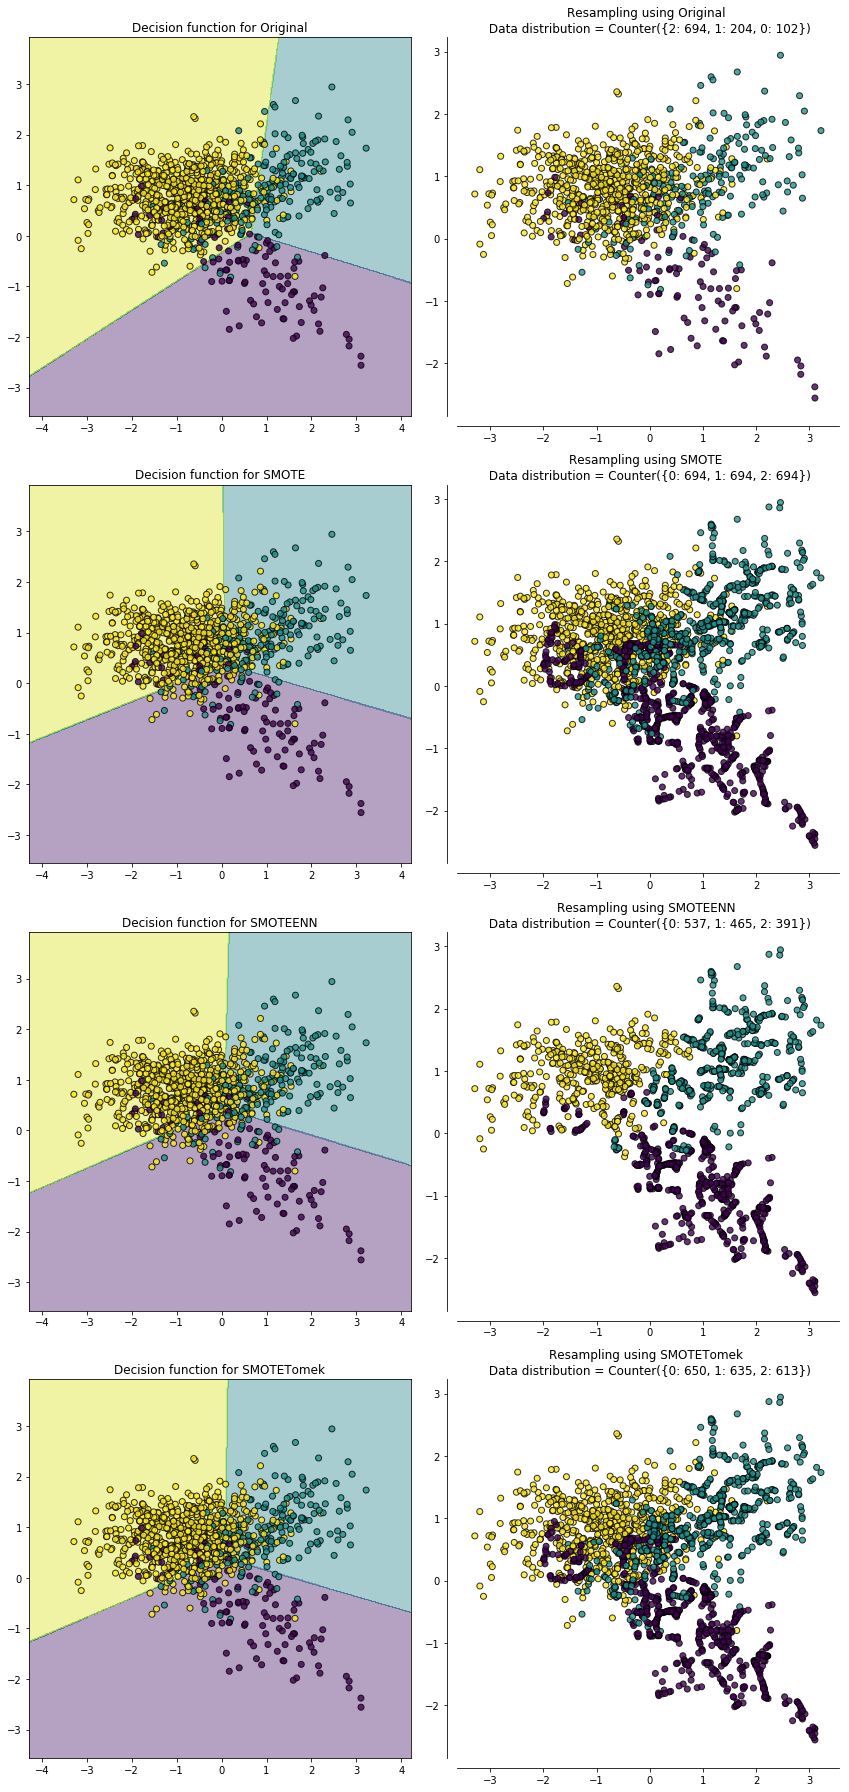

In [15]:
fig, ((ax1, ax2), (ax3, ax4), (ax5, ax6), (ax7, ax8)) = plt.subplots(4, 2, figsize=(12, 25))
X, y = create_dataset(n_samples=1000, weights=(0.1, 0.2, 0.7), class_sep=0.8)

ax_arr = ((ax1, ax2), (ax3, ax4), (ax5, ax6), (ax7, ax8))
for name, ax, sampler in zip(names, ax_arr, 
                            (Original(),
                            SMOTE(random_state=42),
                            SMOTEENN(random_state=42),  # ratio='minority', n_neighbors=?, m_neightbors=?
                            SMOTETomek(random_state=42))):   # ratio='minprity, n_neighbors=?
    clf = make_pipeline(sampler, LinearSVC())   # LR, NB, SVM, RF, GBDT
    clf.fit(X, y)
    plot_decision_function(X, y, clf, ax[0])
    ax[0].set_title('Decision function for {}'.format(sampler.__class__.__name__))
    X_res, y_res = sampler.fit_sample(X, y)
    plot_resampling(X, y, sampler, ax[1])
    ax[1].set_title('Resampling using {} \n Data distribution = {}'.format(sampler.__class__.__name__, Counter(y_res)))
fig.tight_layout()

http://scikit-learn.org/stable/modules/generated/sklearn.metrics.classification_report.html#sklearn.metrics.classification_report

http://scikit-learn.org/stable/auto_examples/model_selection/plot_roc_crossval.html#sphx-glr-auto-examples-model-selection-plot-roc-crossval-py

-----

最后当然还有一个问题，本文列举了多种不同的采样方法，那么哪种方法效果好呢？ 下面用两个数据集对各类方法进行比较，同样结论也是基于这两个数据集。

In [14]:
from collections import Counter
import matplotlib.pyplot as plt
%matplotlib inline
plt.style.use('seaborn')
import seaborn as sns
import numpy as np
import warnings
warnings.filterwarnings("ignore")
import time

from sklearn.datasets import make_classification
from sklearn.svm import LinearSVC
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.metrics import classification_report, f1_score, precision_recall_curve, roc_curve, roc_auc_score, auc
from sklearn.model_selection import train_test_split

from imblearn.pipeline import make_pipeline
from imblearn.over_sampling import ADASYN, SMOTE, RandomOverSampler
from imblearn.base import SamplerMixin
from imblearn.utils import hash_X_y
from imblearn.under_sampling import RandomUnderSampler, NearMiss, EditedNearestNeighbours, TomekLinks
from imblearn.combine import SMOTEENN, SMOTETomek
from imblearn.datasets import fetch_datasets
from imblearn.metrics import classification_report_imbalanced
from imblearn.ensemble import EasyEnsemble, BalanceCascade
from imblearn.combine import SMOTEENN, SMOTETomek

In [15]:
def create_dataset(n_samples=1000, weights=(0.01, 0.01, 0.98), n_classes=3,
                   class_sep=0.8, n_clusters=1):
    return make_classification(n_samples=n_samples, n_features=2,
                               n_informative=2, n_redundant=0, n_repeated=0,
                               n_classes=n_classes,
                               n_clusters_per_class=n_clusters,
                               weights=list(weights),
                               class_sep=class_sep, random_state=0)

In [16]:
def plot_resampling(X, y, sampling, ax):
    X_res, y_res = sampling.fit_sample(X, y)
    ax.scatter(X_res[:, 0], X_res[:, 1], c=y_res, alpha=0.8, edgecolor='k')
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.get_xaxis().tick_bottom()
    ax.get_yaxis().tick_left()
    ax.spines['left'].set_position(('outward', 10))
    ax.spines['bottom'].set_position(('outward', 10))
    return Counter(y_res)

In [17]:
def plot_decision_function(X, y, clf, ax):
    plot_step = 0.02
    x_min, x_max = X[:, 0].min() - 1, X[:, 0].max() + 1
    y_min, y_max = X[:, 1].min() - 1, X[:, 1].max() + 1
    xx, yy = np.meshgrid(np.arange(x_min, x_max, plot_step),
                         np.arange(y_min, y_max, plot_step))

    Z = clf.predict(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)
    ax.contourf(xx, yy, Z, alpha=0.4)
    ax.scatter(X[:, 0], X[:, 1], alpha=0.8, c=y, edgecolor='k')

In [18]:
class Original(SamplerMixin):

    def fit(self, X, y):
        self.ratio_ = 1
        self.X_hash_ = hash_X_y(X, y)
        return self

    def sample(self, X, y):
        return X,

    def _sample(self, X, y):
        pass

    def fit_sample(self, X, y):
        return X, y

第一个数据集为“us_crime"，多数类样本和少数类样本的比例为12:1。

In [19]:
us_crime = fetch_datasets()['us_crime']
us_crime.data.shape

(1994, 100)

In [20]:
print(sorted(Counter(us_crime.target).items()))

[(-1, 1844), (1, 150)]


In [21]:
print("多数类：少数类 = {:.0f}:1".format(max(Counter(us_crime.target).values()) / min(Counter(us_crime.target).values())))

多数类：少数类 = 12:1


In [22]:
X_train, X_test, y_train, y_test = train_test_split(us_crime.data, us_crime.target, 
                                                    test_size=0.5, random_state=42, stratify=us_crime.target)

In [23]:
list(Counter(y_train).items()), list(Counter(y_test).items())

([(1, 75), (-1, 922)], [(1, 75), (-1, 922)])

----

总共是9个模型，1个 base_model 加上8个过采样和欠采样方法。`imbalanced-learn` 中大部分采样方法都可以使用`make_pipeline`将采样方法和分类模型连接起来，但两种集成方法，`EasyEnsemble`和`BalanceCascade`无法使用`make_pipeline`(因为本质上是集成了好几个分类模型)，所以需要自定义方法。

In [24]:
sampling_methods = [Original(), 
                    SMOTE(random_state=42), 
                    SMOTE(random_state=42, kind='borderline1'), 
                    ADASYN(random_state=42), 
                    EasyEnsemble(random_state=42), 
                    BalanceCascade(random_state=42),
                    NearMiss(version=3, random_state=42), 
                    SMOTEENN(random_state=42), 
                    SMOTETomek(random_state=42)]

names = ['Base model', 
         'SMOTE', 
         'Borderline SMOTE', 
         'ADASYN', 
         'EasyEnsemble', 
         'BalanceCascade', 
         'NearMiss', 
         'SMOTE+ENN', 
         'SMOTE+Tomek']

In [25]:
def ensemble_method(method):
    count = 0
    xx, yy = method.fit_sample(X_train, y_train)
    y_pred, y_prob = np.zeros(len(X_test)), np.zeros(len(X_test))
    for X_ensemble, y_ensemble in zip(xx, yy):
        model = LogisticRegression()  
        model.fit(X_ensemble, y_ensemble)
        y_pred += model.predict(X_test)
        y_prob += model.predict_proba(X_test)[:, 1]
        count += 1
    return np.where(y_pred >= 0, 1, -1), y_prob/count

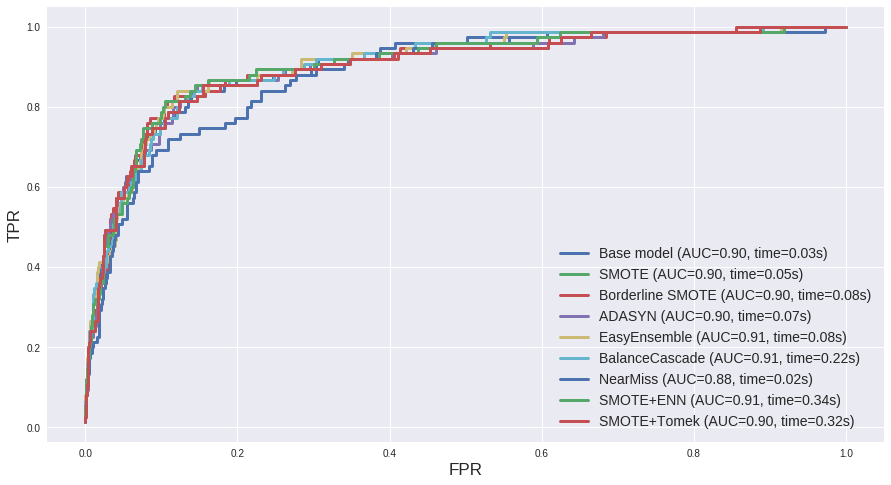

In [26]:
plt.figure(figsize=(15,8))
for (name, method) in zip(names, sampling_methods):
    t0 = time.time()
    if name == 'EasyEnsemble' or name == 'BalanceCascade':
        y_pred, y_prob = ensemble_method(method)
    else:
        model = make_pipeline(method, LogisticRegression())  
        model.fit(X_train, y_train)
        y_pred = model.predict(X_test)
        y_prob = model.predict_proba(X_test)[:, 1]
    fpr, tpr, thresholds = roc_curve(y_test, y_prob, pos_label=1)
    plt.plot(fpr, tpr, lw=3, label='{} (AUC={:.2f}, time={:.2f}s)'.
             format(name, auc(fpr, tpr), time.time() - t0))
    plt.xlabel("FPR", fontsize=17)
    plt.ylabel("TPR", fontsize=17)
    plt.legend(fontsize=14)

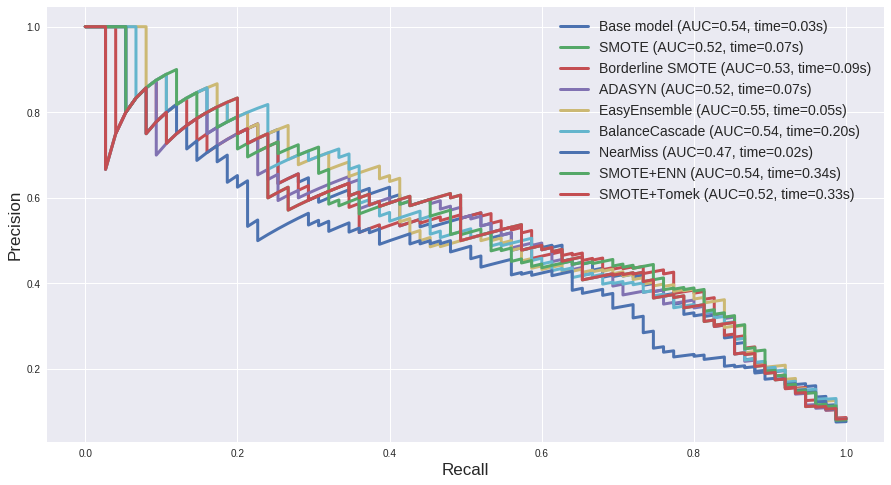

In [27]:
plt.figure(figsize=(15,8))
for (name, method) in zip(names, sampling_methods):
    t0 = time.time()
    if name == 'EasyEnsemble' or name == 'BalanceCascade':
        y_pred, y_prob = ensemble_method(method)
    else:
        model = make_pipeline(method, LogisticRegression())
        model.fit(X_train, y_train)
        y_pred = model.predict(X_test)
        y_prob = model.predict_proba(X_test)[:, 1]
    precision, recall, thresholds = precision_recall_curve(y_test, y_prob, pos_label=1)
    plt.plot(recall, precision, lw=3, label='{} (AUC={:.2f}, time={:.2f}s)'.
             format(name, auc(recall, precision), time.time() - t0))
    plt.xlabel("Recall", fontsize=17)
    plt.ylabel("Precision", fontsize=17)
    plt.legend(fontsize=14, loc="upper right")

----

第二个数据集是”abalone“，多数类样本和少数类样本的比例为130:1，非常悬殊。

In [31]:
abalone_19 = fetch_datasets()['abalone_19']
abalone_19.data.shape

(4177, 10)

In [32]:
print(sorted(Counter(abalone_19.target).items()))

[(-1, 4145), (1, 32)]


In [33]:
print('多数类：少数类 = {:.0f}：1'.format(max(Counter(abalone_19.target).values()) / min(Counter(abalone_19.target).values())))

多数类：少数类 = 130：1


In [34]:
X_train, X_test, y_train, y_test = train_test_split(abalone_19.data, abalone_19.target, test_size=0.5, 
                                                    random_state=42, stratify=abalone_19.target)

In [35]:
list(Counter(y_train).items()), list(Counter(y_test).items())

([(1, 16), (-1, 2072)], [(1, 16), (-1, 2073)])

In [36]:
def ensemble_method(method):
    count = 0
    xx, yy = method.fit_sample(X_train, y_train)
    y_pred, y_prob = np.zeros(len(X_test)), np.zeros(len(X_test))
    for X_ensemble, y_ensemble in zip(xx, yy):
        model = LogisticRegression()  
        model.fit(X_ensemble, y_ensemble)
        y_pred += model.predict(X_test)
        y_prob += model.predict_proba(X_test)[:, 1]
        count += 1
    return np.where(y_pred >= 0, 1, -1), y_prob/count

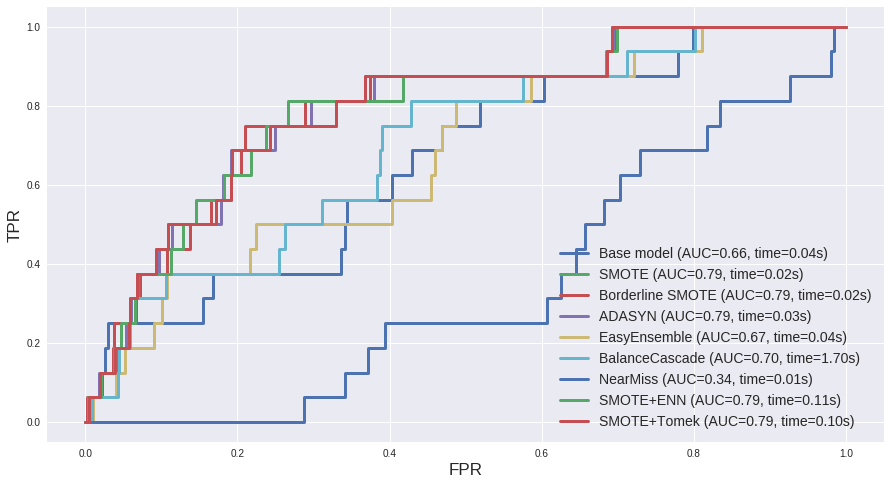

In [37]:
plt.figure(figsize=(15,8))
for (name, method) in zip(names, sampling_methods):
    t0 = time.time()
    if name == 'EasyEnsemble' or name == 'BalanceCascade':
        y_pred, y_prob = ensemble_method(method)
    else:
        model = make_pipeline(method, LogisticRegression()) 
        model.fit(X_train, y_train)
        y_pred = model.predict(X_test)
        y_prob = model.predict_proba(X_test)[:, 1]
    fpr, tpr, thresholds = roc_curve(y_test, y_prob, pos_label=1)
    plt.plot(fpr, tpr, lw=3, label='{} (AUC={:.2f}, time={:.2f}s)'.
             format(name, auc(fpr, tpr), time.time() - t0))
    plt.xlabel("FPR", fontsize=17)
    plt.ylabel("TPR", fontsize=17)
    plt.legend(fontsize=14)

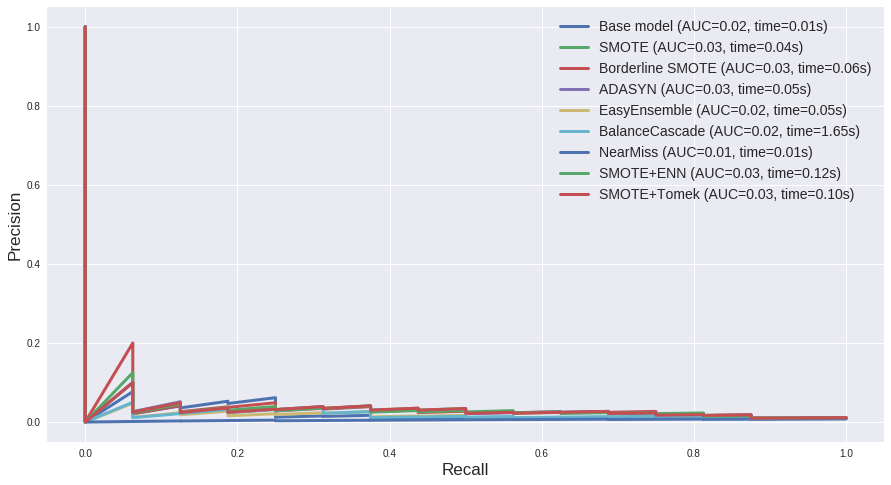

In [38]:
plt.figure(figsize=(15,8))
for (name, method) in zip(names, sampling_methods):
    t0 = time.time()
    if name == 'EasyEnsemble' or name == 'BalanceCascade':
        y_pred, y_prob = ensemble_method(method)
    else:
        model = make_pipeline(method, LogisticRegression())
        model.fit(X_train, y_train)
        y_pred = model.predict(X_test)
        y_prob = model.predict_proba(X_test)[:, 1]
    precision, recall, thresholds = precision_recall_curve(y_test, y_prob, pos_label=1)
    plt.plot(recall, precision, lw=3, label='{} (AUC={:.2f}, time={:.2f}s)'.
             format(name, auc(recall, precision), time.time() - t0))
    plt.xlabel("Recall", fontsize=17)
    plt.ylabel("Precision", fontsize=17)
    plt.legend(fontsize=14, loc="best")

----

从以上几张图中我们可以得出一些推论：
0. 就时间开销而言，BalanceCascade以及两种过采样欠采样结合的方法(`SMOTE + ENN` 和` SMOTE + Tomek`)耗时最高，如果追求速度的话这几个可能并非很好的选择。

1. 第一个数据集 `us_crime` 的多数类和少数类样本比例为 12:1，相差不是很悬殊，综合ROC曲线和PR曲线的AUC来看，两种集成方法`EasyEnsemble`和`BalanceCascade`表现较好。  
对于第二个数据集 `abalone_19` 来说，多数类和少数类样本比例为 130:1，而且少数类样本非常少，因而从结果来看几种过采样方法如`Borderline SMOTE， SMOTE+Tomek`等效果较好。可见在类别差异很大的情况下，过采样能一定程度上弥补少数类样本的极端不足。然而从PR曲线上来看，其实结果都不尽如人意，对于这种极端不平衡的数据可能比较适合异常检测的方法，以后有机会详述。   
<br> 
2. 上篇文章中提到 “**ROC曲线通常会呈现一个过分乐观的效果估计**”，这里再一次得到体现。第一个数据集中大部分ROC曲线的AUC都在0.9左右，而PR曲线都在0.5左右。第二个数据集则更夸张，从PR曲线来看其实模型对于少数类的预测准确率是无限接近于0了，但在ROC曲线上却很难看出这一点。  
<br>  

3. 如果单纯从ROC曲线和PR曲线上来看，表面上各种采样方法和base model差别不大，但实际上这其中却是暗流涌动。下面来看一下us_crime数据集中各方法的classification report。

In [74]:
def ensemble_method_2(method):
    xx, yy = method.fit_sample(X_train, y_train)
    y_pred, y_prob = np.zeros(len(X_test)), np.zeros(len(X_test))
    for X_ensemble, y_ensemble in zip(xx, yy):
        model = LogisticRegression()
        model.fit(X_ensemble, y_ensemble)
        y_pred += model.predict(X_test)
    return np.where(y_pred >= 0, 1, -1)

In [75]:
us_crime = fetch_datasets()['us_crime']
X_train, X_test, y_train, y_test = train_test_split(us_crime.data, us_crime.target, 
                                                    test_size=0.5, random_state=42, stratify=us_crime.target)

class_names = ['majority class', 'minority class']

model = LogisticRegression()
model.fit(X_train, y_train)
y_pred = model.predict(X_test)
print("------------------------Base Model---------------------- \n", 
      classification_report(y_test, y_pred, target_names=class_names), '\n')

model = make_pipeline(SMOTE(random_state=42), LogisticRegression())
model.fit(X_train, y_train)
y_pred = model.predict(X_test)
print("--------------------------SMOTE------------------------ \n",
      classification_report(y_test, y_pred, target_names=class_names), '\n')

model = make_pipeline(NearMiss(version=2, random_state=42), LogisticRegression())
model.fit(X_train, y_train)
y_pred = model.predict(X_test)
print("------------------------NearMiss------------------------ \n",
      classification_report(y_test, y_pred, target_names=class_names), '\n')

y_pred = ensemble_method_2(EasyEnsemble(random_state=42))
class_names = ['majority class', 'minority class']
print("-----------------------EasyEnsemble--------------------- \n",
      classification_report(y_test, y_pred, target_names=class_names), '\n')

------------------------Base Model---------------------- 
                 precision    recall  f1-score   support

majority class       0.95      0.98      0.97       922
minority class       0.62      0.35      0.44        75

   avg / total       0.92      0.93      0.93       997
 

--------------------------SMOTE------------------------ 
                 precision    recall  f1-score   support

majority class       0.98      0.90      0.94       922
minority class       0.38      0.75      0.51        75

   avg / total       0.93      0.89      0.91       997
 

------------------------NearMiss------------------------ 
                 precision    recall  f1-score   support

majority class       0.97      0.81      0.88       922
minority class       0.24      0.73      0.36        75

   avg / total       0.92      0.80      0.84       997
 

-----------------------EasyEnsemble--------------------- 
                 precision    recall  f1-score   support

majority class       

这里我们主要关注少数类样本，可以看到Base Model的特点是precision高，recall低，而几种采样方法则相反，precision低，recall高。采样方法普遍扩大了少数类样本的决策边界（从上文中的决策边界图就能看出来），所以把很多多数类样本也划为少数类了，导致precision下降而recall提升。当然这些都是分类阈值为0.5的前提下得出的结论，如果进一步调整阈值的话能得到更好的模型。策略是base model的阈值往下调，采样方法的阈值往上调。

In [89]:
def ensemble_method_3(method):
    xx, yy = method.fit_sample(X_train, y_train)
    y_pred, y_prob = np.zeros(len(X_test)), np.zeros(len(X_test))
    for X_ensemble, y_ensemble in zip(xx, yy):
        model = LogisticRegression()
        model.fit(X_ensemble, y_ensemble)
        y_pred += np.where(model.predict_proba(X_test)[:, 1] >= 0.7, 1, -1)
    return np.where(y_pred >= 0, 1, -1)

In [113]:
us_crime = fetch_datasets()['us_crime']
X_train, X_test, y_train, y_test = train_test_split(us_crime.data, us_crime.target, 
                                                    test_size=0.5, random_state=42, stratify=us_crime.target)

model = LogisticRegression()
model.fit(X_train, y_train)
y_pred = np.where(model.predict_proba(X_test)[:, 1] >= 0.3, 1, -1)
print("-----------------Base Model, threshold >= 0.3--------------- \n", 
      classification_report(y_test, y_pred, target_names=class_names), '\n')

model = make_pipeline(SMOTE(random_state=42), LogisticRegression())
model.fit(X_train, y_train)
y_pred = np.where(model.predict_proba(X_test)[:, 1] >= 0.9, 1, -1)
print("-----------------SMOTE, threshold >= 0.9--------------- \n", 
      classification_report(y_test, y_pred, target_names=class_names), '\n')

model = make_pipeline(NearMiss(version=2, random_state=42), LogisticRegression())
model.fit(X_train, y_train)
y_pred = np.where(model.predict_proba(X_test)[:, 1] >= 0.7, 1, -1)
print("-------------------NearMiss, threshold >= 0.7------------------- \n",
      classification_report(y_test, y_pred, target_names=class_names), '\n')

model = EasyEnsemble(random_state=42)
y_pred = ensemble_method_3(model)
class_names = ['majority class', 'minority class']
print("--------------EasyEnsemble, threshold >= 0.7-------------- \n",
      classification_report(y_test, y_pred, target_names=class_names), '\n')

-----------------Base Model, threshold >= 0.3--------------- 
                 precision    recall  f1-score   support

majority class       0.96      0.96      0.96       922
minority class       0.53      0.53      0.53        75

   avg / total       0.93      0.93      0.93       997
 

-----------------SMOTE, threshold >= 0.9--------------- 
                 precision    recall  f1-score   support

majority class       0.96      0.97      0.97       922
minority class       0.60      0.49      0.54        75

   avg / total       0.93      0.94      0.93       997
 

-------------------NearMiss, threshold >= 0.7------------------- 
                 precision    recall  f1-score   support

majority class       0.96      0.90      0.93       922
minority class       0.32      0.59      0.42        75

   avg / total       0.92      0.88      0.89       997
 

--------------EasyEnsemble, threshold >= 0.7-------------- 
                 precision    recall  f1-score   support

majorit

可以看到在经过阈值调整后，各方法的整体F1分数都有提高，可见很多单指标如precision，recall等都会受到不同阈值的影响。所以这也是为什么在类别不平衡问题中用ROC和PR曲线来评估非常流行，因为它们不受特定阈值变化的影响，反映的是模型的整体预测能力。

不过在这里我不得不得出一个比较悲观的结论，就这两个数据集的结果来看，如果本身数据偏斜不是很厉害，那么采样方法的提升效果很细微。如果本身数据偏斜很厉害，采样方法纵使比base model好很多，但由于base model本身的少数类预测能力很差，所以本质上也不尽如人意。这就像考试原来一直靠30分，采样了之后考了50分，绝对意义上提升很大，但其实还是差得远了。

本文**代码**主要来自于[imbalanced-learn](https://github.com/scikit-learn-contrib/imbalanced-learn)这个库，算是scikit-learn的姐妹项目。

---